last version with right number of exposure for the whole LSST survey (https://arxiv.org/pdf/0805.2366.pdf)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils, boxplot, layers

In [4]:
from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

set_matplotlib_formats('retina')

# Loading the trained VAE

In [4]:
vae_lsst_01,vae_lsst_01_utils, encoder_LSST_01, Dkl_01 = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/miscentered_01_v1/bis_bis/mse/',6, folder= True)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
vae_lsst_peak,vae_lsst_peak_utils, encoder_LSST_peak, Dkl_peak = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/miscentered_peak_v1/bis_bis/mse/',6, folder= True)

# Load data

In [5]:
data_dir_01 = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/miscentered_0.1/test/"
root_01 = 'galaxies_isolated_20191024'

images_01 = np.load(data_dir_01+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

test_sample_01 = [data_dir_01+'galaxies_isolated_20191024_0_images.npy']

In [6]:
data_dir_peak = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/miscentered_peak/test/"
root_peak = 'galaxies_isolated_20191024'

images_peak = np.load(data_dir_peak+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

test_sample_peak = [data_dir_peak+'galaxies_isolated_20191024_0_images.npy']

# Parameters to fix

In [7]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

In [8]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

## load LSST center results

In [22]:
df_lsst_centered = pd.read_csv('data_v2/df_vae_centered_lsst_2.csv', encoding = 'utf-8')

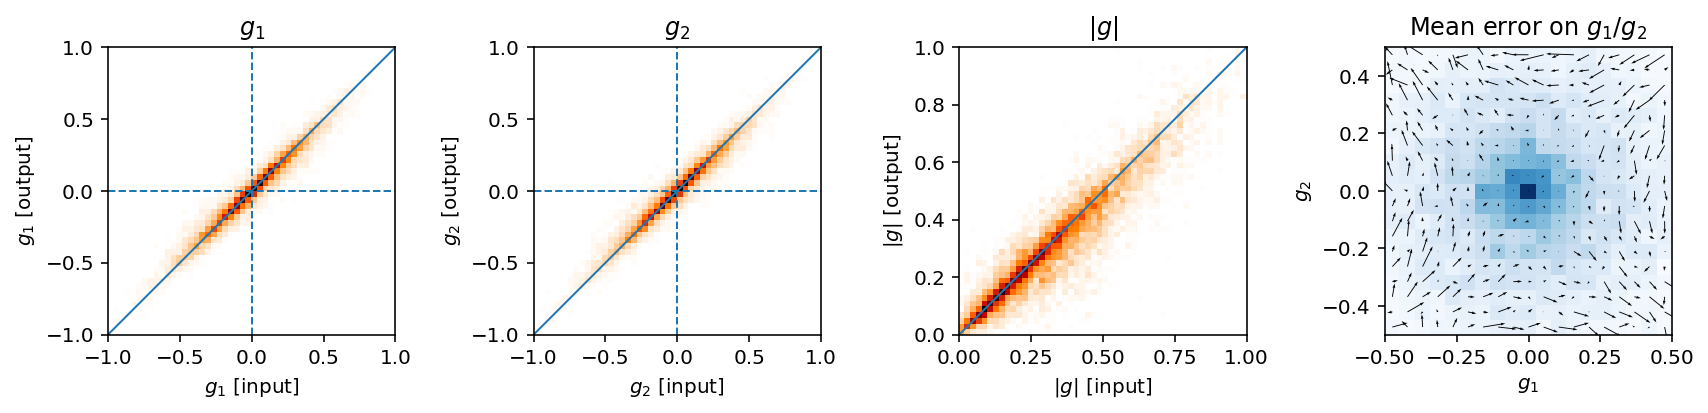

In [10]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_centered['e1_in'], df_lsst_centered['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_centered['e2_in'], df_lsst_centered['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_centered['e_in'], df_lsst_centered['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_centered['e1_in'], df_lsst_centered['e2_in'], values=df_lsst_centered['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_centered['e1_in'], df_lsst_centered['e2_in'], values=df_lsst_centered['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_centered['e1_in'], df_lsst_centered['e2_in'], values=df_lsst_centered['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_centered['e1_in'], df_lsst_centered['e2_in'], values=df_lsst_centered['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_centered['e1_in'], df_lsst_centered['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

## LSST miscentered 0.1

In [11]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [12]:
df_lsst_01 = results_processing.processing(vae_lsst_01,
                                           data_dir_01,
                                           root_01,
                                           test_sample_01[0],
                                           bands_lsst,
                                           2,
                                           stamp_size,  
                                           batch_size,
                                           PSF, 
                                           pix_scale_lsst,
                                           cut_mag = 27.5)


(10000, 2, 2)


In [11]:
df_lsst_01.to_csv('data_v2/df_vae_lsst_miscenter_01.csv')

NameError: name 'df_lsst_01' is not defined

In [12]:
df_lsst_01 = pd.read_csv('data_v2/df_vae_lsst_miscenter_01.csv', encoding = 'utf-8')

### Shape plots

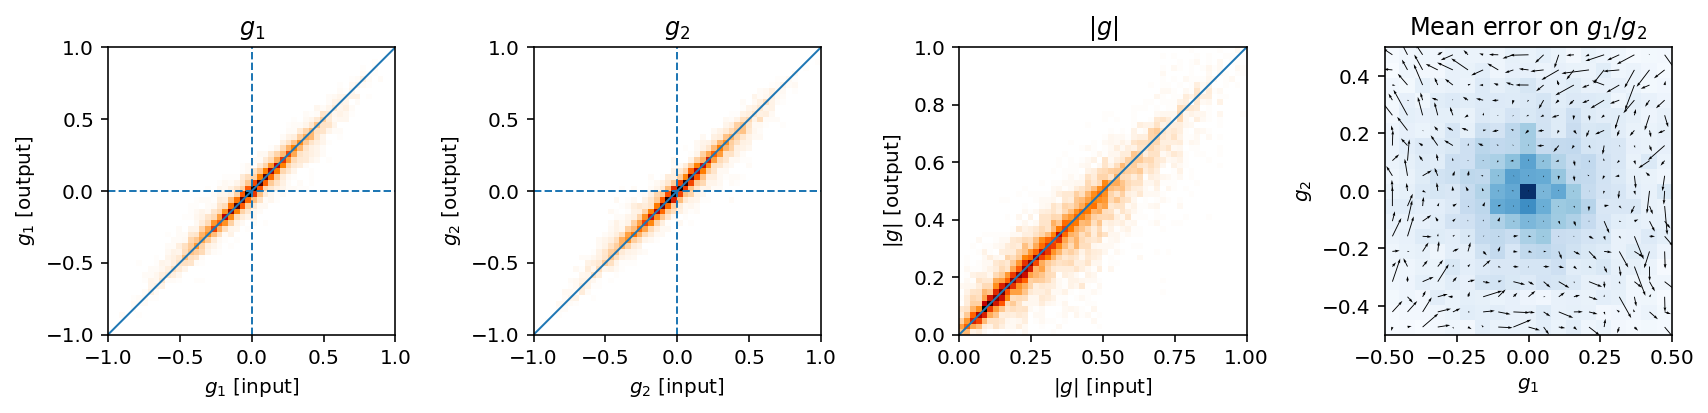

In [13]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_01['e1_in'], df_lsst_01['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_01['e2_in'], df_lsst_01['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_01['e_in'], df_lsst_01['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_01['e1_in'], df_lsst_01['e2_in'], values=df_lsst_01['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_01['e1_in'], df_lsst_01['e2_in'], values=df_lsst_01['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_01['e1_in'], df_lsst_01['e2_in'], values=df_lsst_01['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_01['e1_in'], df_lsst_01['e2_in'], values=df_lsst_01['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_01['e1_in'], df_lsst_01['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

## LSST miscentered peak

In [14]:
df_lsst_peak = results_processing.processing(vae_lsst_peak,
                                           data_dir_peak,
                                           root_peak,
                                           test_sample_peak[0],
                                           bands_lsst,
                                           2,
                                           stamp_size,  
                                           batch_size,
                                           PSF, 
                                           pix_scale_lsst,
                                           cut_mag = 27.5)


(10000, 2, 2)


In [17]:
df_lsst_peak.to_csv('data_v2/df_vae_lsst_miscenter_peak.csv')

In [13]:
df_lsst_peak = pd.read_csv('data_v2/df_vae_lsst_miscenter_peak.csv', encoding = 'utf-8')

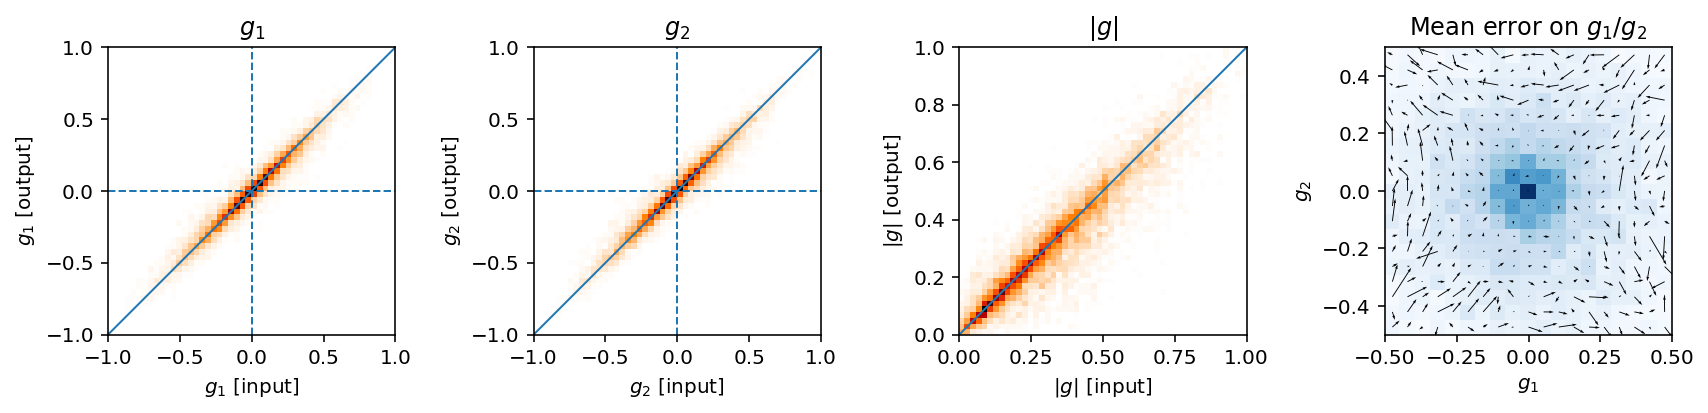

In [15]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e1_in'], df_lsst_peak['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e2_in'], df_lsst_peak['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e_in'], df_lsst_peak['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_peak['e1_in'], df_lsst_peak['e2_in'], values=df_lsst_peak['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_peak['e1_in'], df_lsst_peak['e2_in'], values=df_lsst_peak['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_peak['e1_in'], df_lsst_peak['e2_in'], values=df_lsst_peak['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_peak['e1_in'], df_lsst_peak['e2_in'], values=df_lsst_peak['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_peak['e1_in'], df_lsst_peak['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

# Delta WL parameters

## As function of SNR

In [23]:
df_plot = pd.concat([df_lsst_centered, df_lsst_01, df_lsst_peak], ignore_index=True)
df_plot['exp'] = [1]*10000 + [2]*10000 + [3]*10000

In [24]:
df_plot = df_plot.drop('Unnamed: 0', axis = 1)

In [25]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

df_plot = df_plot[(df_plot['e1_out']<=1.) & 
                  (df_plot['e2_out']<=1.) &
                  (df_plot['e1_out']>=-1.) & 
                  (df_plot['e2_out']>=-1.) &
                  (df_plot['e_out']>=0.) & 
                  (df_plot['e_out']<=1.) ]

In [26]:
df_plot

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,idx_closest_to_peak,...,e_error,e_in_obs,e_out_obs,e_obs_error,flux_in,flux_out,mag_in,mag_out,delta_mag,exp
0,1,45.464150,0.056616,0.3596,1.723946,-0.367390,0.123614,26.808765,-0.635824,0,...,-0.003660,0.148396,0.154945,0.006549,8.089245e+04,7.643477e+04,26.739510,26.801054,0.061544,1
1,1,46.436494,0.056182,0.4936,1.771745,-0.392054,-0.034119,26.765029,-0.721610,0,...,-0.066134,0.185806,0.167842,-0.017964,8.418453e+04,8.739853e+04,26.696199,26.655521,-0.040677,1
2,1,104.866322,0.130824,0.6002,1.775913,0.085734,-0.176718,25.862318,-2.084892,0,...,0.009637,0.099278,0.105637,0.006359,1.934510e+05,1.872635e+05,25.792852,25.828148,0.035296,1
3,1,431.557372,0.299869,0.1662,3.670538,-0.255536,-0.083613,23.508441,-3.215953,0,...,-0.002535,0.383366,0.384044,0.000678,1.690524e+06,1.676931e+06,23.439227,23.447994,0.008768,1
4,1,26.795127,0.030990,0.9843,1.886864,0.388271,0.290140,27.294193,-1.544869,0,...,-0.024810,0.267339,0.268342,0.001003,5.172917e+04,5.508095e+04,27.224941,27.156776,-0.068164,1
5,1,38.005971,0.046546,2.2614,1.739168,-0.364687,0.119250,27.024618,-1.140981,0,...,-0.116125,0.169379,0.148357,-0.021022,6.630832e+04,6.438486e+04,26.955360,26.987322,0.031962,1
6,1,152.220224,0.138834,0.3694,2.673135,-0.186761,0.353444,24.970630,-2.043902,0,...,0.013654,0.419678,0.435809,0.016132,4.391760e+05,4.366919e+05,24.902683,24.908844,0.006161,1
7,1,70.657888,0.071285,0.7990,2.255868,0.301392,-0.411277,26.059101,-1.712600,0,...,0.011115,0.419495,0.429234,0.009740,1.613498e+05,1.616574e+05,25.989858,25.987793,-0.002065,1
8,1,27.157095,0.032312,0.1980,1.826188,-0.193005,-0.345397,27.321017,0.337554,0,...,-0.071250,0.209723,0.189909,-0.019813,5.046168e+04,4.911852e+04,27.251875,27.281168,0.029293,1
9,1,28.696331,0.032439,0.7842,1.943995,-0.268139,0.110842,27.173985,-1.285371,0,...,-0.037364,0.188457,0.185629,-0.002828,5.778527e+04,5.733483e+04,27.104737,27.113235,0.008499,1


In [27]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29788 entries, 0 to 29999
Data columns (total 29 columns):
nb_blended_gal         29788 non-null int64
SNR                    29788 non-null float64
SNR_peak               29788 non-null float64
redshift               29788 non-null float64
moment_sigma           29788 non-null float64
e1                     29788 non-null float64
e2                     29788 non-null float64
mag                    29788 non-null float64
mag_ir                 29788 non-null float64
idx_closest_to_peak    29788 non-null int64
n_peak_detected        29788 non-null int64
e1_in                  29788 non-null float64
e1_out                 29788 non-null float64
e1_error               29788 non-null float64
e2_in                  29788 non-null float64
e2_out                 29788 non-null float64
e2_error               29788 non-null float64
e_in                   29788 non-null float64
e_out                  29788 non-null float64
e_error                

In [28]:
np.min(df_plot['SNR']), np.max(df_plot['SNR'])

(10.231580610118447, 4138.153073494533)

29788
[1 2 3]
0 1
1 2
2 3


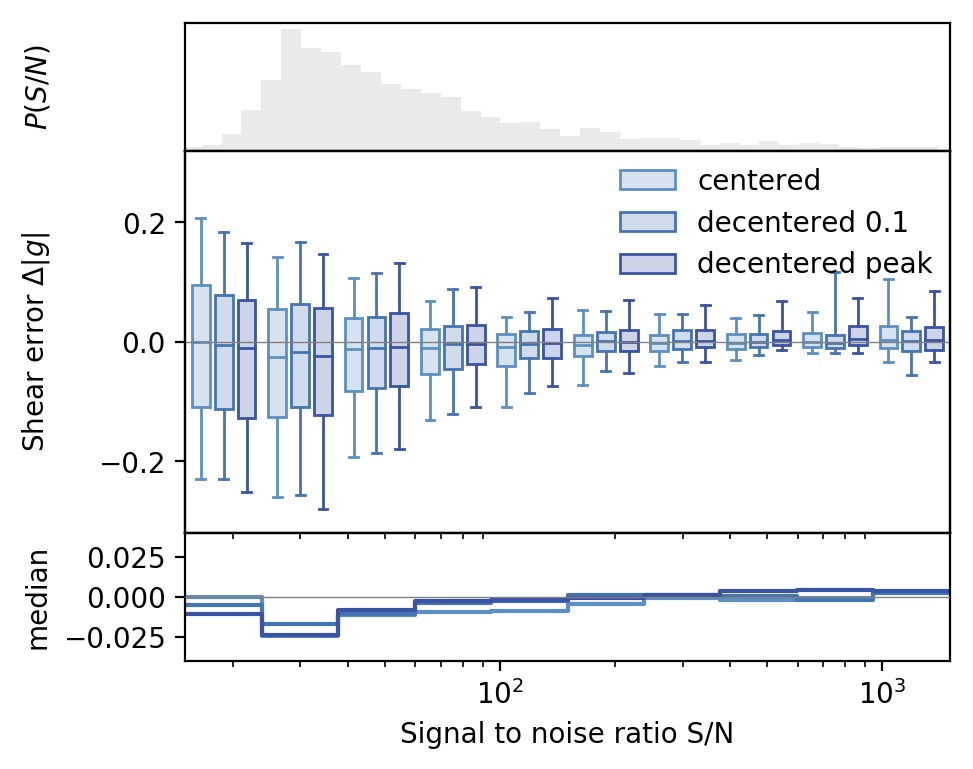

In [29]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 1500.),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.04, 0.04), 
              x_scale = 'log',
              legend = ['centered', 'decentered 0.1', 'decentered peak'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
              nbins = 10)
#fig.savefig('figures_v2/shear_SN_miscentered.pdf')

old figure

29744
[1 2 3]
0 1
1 2
2 3


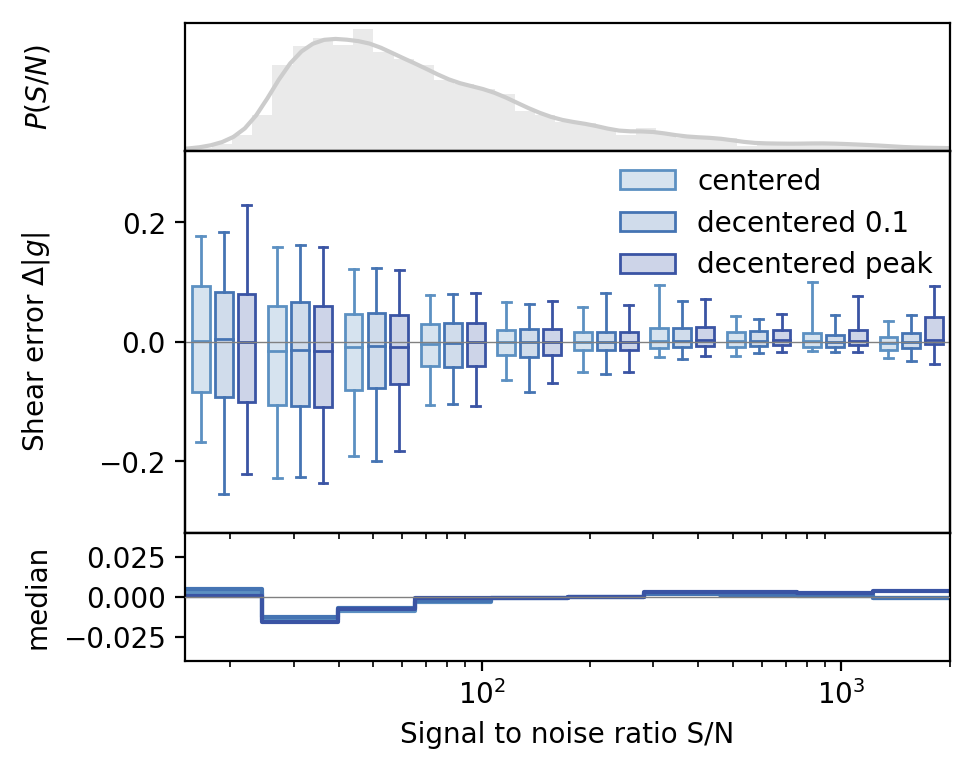

In [18]:
#fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, 
#              x = 'SNR', y = 'e_error', z = 'exp',
#              xlim = (15, 2000.),
#              ylim = (-0.32, 0.32), 
#              ylim2 = (-0.04, 0.04), 
#              x_scale = 'log',
#              legend = ['centered', 'decentered 0.1', 'decentered peak'],
#              x_label='Signal to noise ratio S/N', 
#              y_label = 'Shear error $\\Delta |g|$',
#              y_label_hist='$P(S/N)$',
#              y_label_2 = 'median',
#              legend_remove = False,
#              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
#              nbins = 10)
#fig.savefig('figures_v2/shear_SN_miscentered.pdf')

29788
[1 2 3]
0 1
1 2
2 3


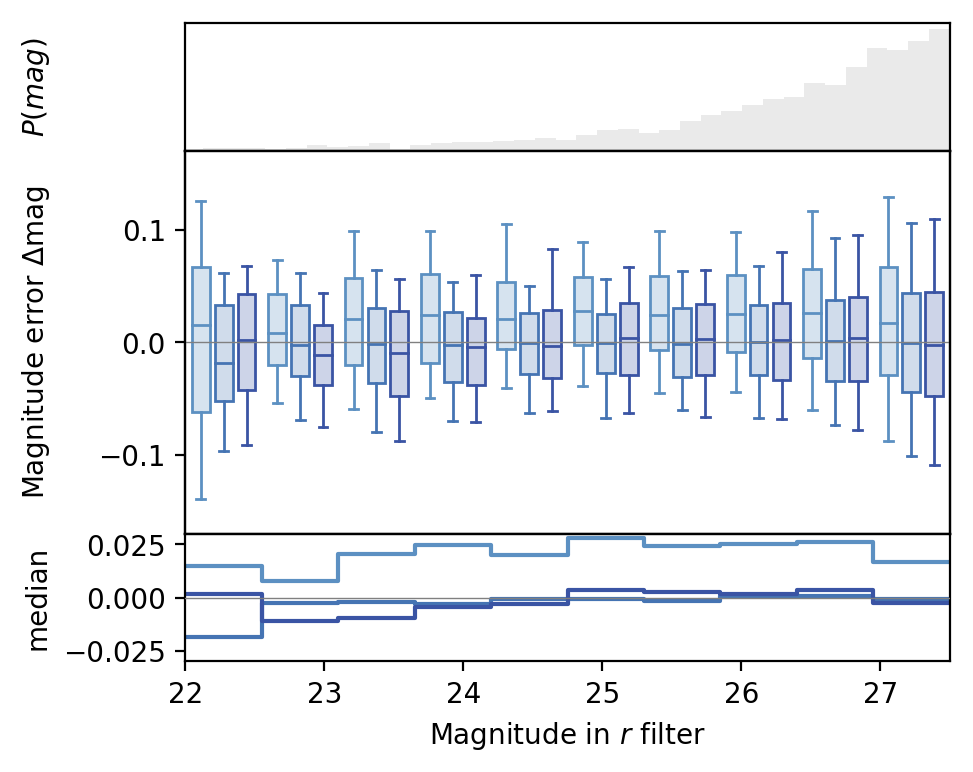

In [30]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot.boxplot_func(df_plot, 
              x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (22, 27.5),
              ylim = (-0.17, 0.17),
              ylim2 = (-0.03, 0.03),
              x_scale = 'linear',
              legend = ['centered', 'decentered 0.1', 'decentered peak'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
              nbins = 10)

old figure

29744
[1 2 3]
0 1
1 2
2 3


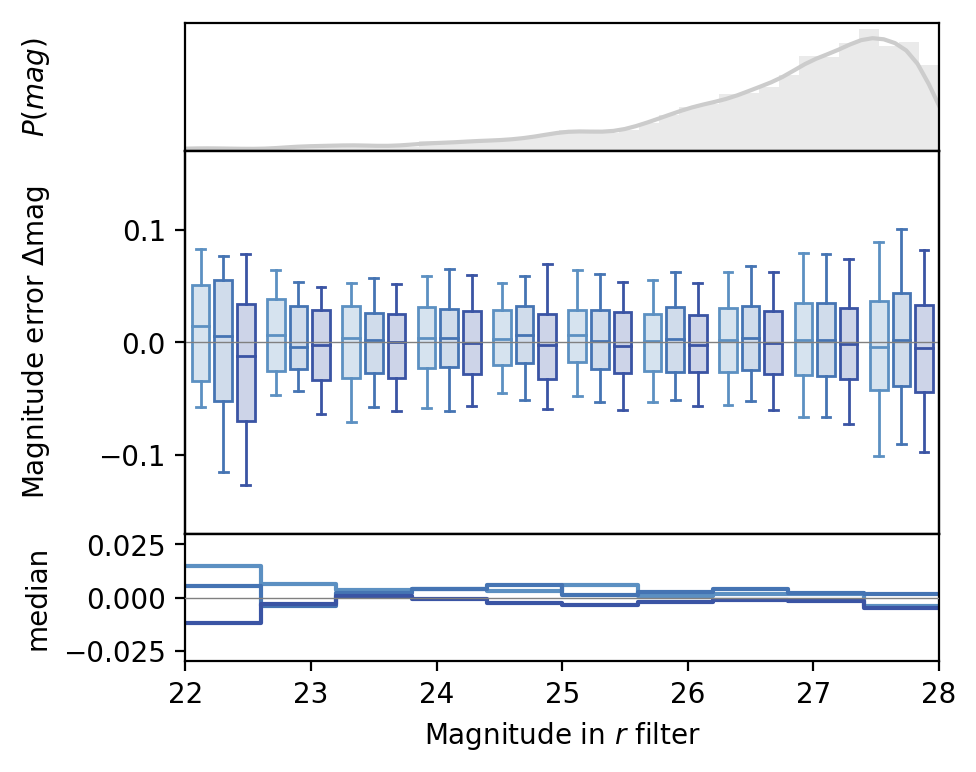

In [19]:
#fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot.boxplot_func(df_plot, 
#              x = 'mag', y = 'delta_mag', z = 'exp',
#              xlim = (22, 28),
#              ylim = (-0.17, 0.17),
#              ylim2 = (-0.03, 0.03),
#              x_scale = 'linear',
#              legend = ['centered', 'decentered 0.1', 'decentered peak'],
#              x_label='Magnitude in $r$ filter', 
#              y_label = 'Magnitude error $\Delta$mag',
#              y_label_hist='$P(mag)$',
#              y_label_2 = 'median',
#              legend_remove = True,
#              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
#              nbins = 10)

#fig.savefig('figures_v2/mag_mag_miscentered.pdf')

In [20]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = median_shear
df_stat['q1_shear'] = q1_shear
df_stat['q3_shear'] = q3_shear
df_stat['whislo_shear'] = whislo_shear
df_stat['whishi_shear'] = whishi_shear
df_stat['median_mag'] = median_mag
df_stat['q1_mag'] = q1_mag
df_stat['q3_mag'] = q3_mag
df_stat['whislo_mag'] = whislo_mag
df_stat['whishi_mag'] = whishi_mag
df_stat['stats_names'] = ['r band']*10 + ['LSST']*10 + ['LSST Euclid']*10

In [21]:
param = 'median_shear'
x =4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.006015874751287132, -0.004284638643268855, -0.005885749043109012]
improvement between each exp: [1.4040565032801635, 0.7279682860901581]


In [22]:
param = 'q1_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.07775029966520275, -0.07948828115922882, -0.08003987657265615]
improvement between each exp: [0.9781353745649048, 0.9931084924534257]


In [23]:
param = 'q3_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.0575029523154203, 0.058001537409824507, 0.05426102304285947]
improvement between each exp: [0.9914039331254044, 1.068935566585438]


In [24]:
param = 'whislo_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.17333641420658263, -0.19601650050923922, -0.18678311207719087]
improvement between each exp: [0.8842950147373559, 1.0494337433902081]


In [25]:
param = 'whishi_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.13413263217272828, 0.13800051032141794, 0.14746284493766665]
improvement between each exp: [0.9719720011202787, 0.9358324151399053]


In [26]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.003843823107905031, 0.002551252224598244, -0.00306001435946861]
improvement between each exp: [1.5066417466859174, -0.8337386446256038]


In [27]:
param = 'q1_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.02744152253032134, -0.02875580437724005, -0.03537648203238675]
improvement between each exp: [0.9542950762330629, 0.8128508750789424]


In [28]:
param = 'q3_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.03367045260491182, 0.03448977204295721, 0.028279497786883094]
improvement between each exp: [0.9762445678961019, 1.2196034138539276]


In [29]:
param = 'whislo_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.0602994592930667, -0.06409154713158571, -0.07147495075857613]
improvement between each exp: [0.9408332610424661, 0.8966994233835901]


In [30]:
param = 'whishi_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.06603408848007604, 0.06825577257527478, 0.06320864465718472]
improvement between each exp: [0.967450605108182, 1.0798486970486936]


29782
[1 2 3]
0 1
1 2
2 3


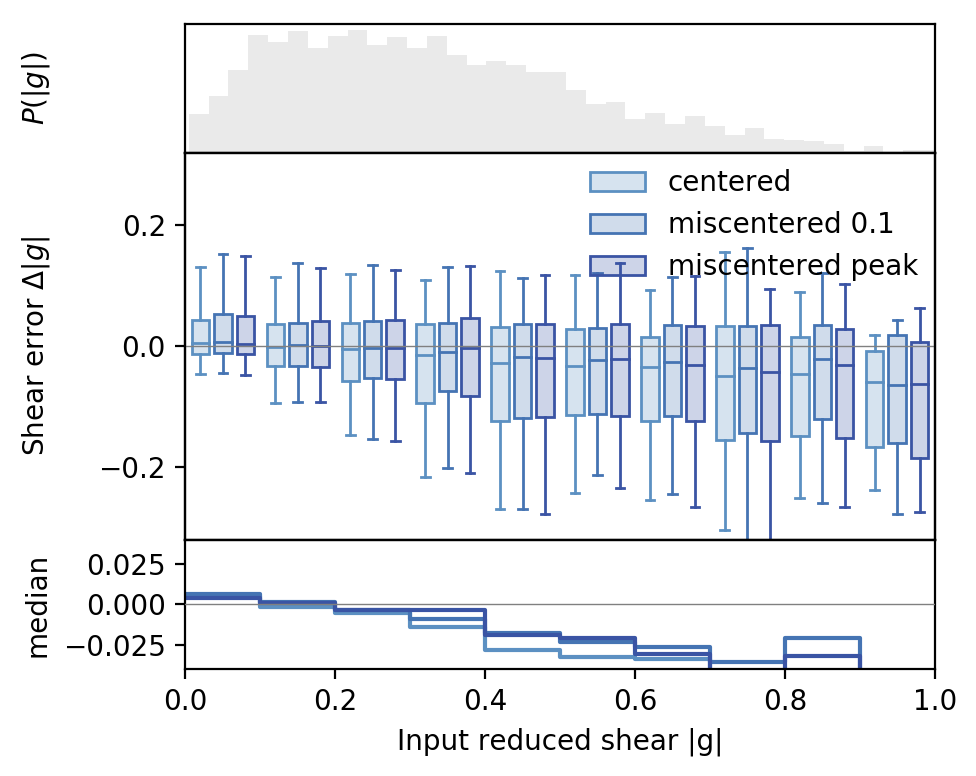

In [27]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, 
              x = 'e_in', y = 'e_error', z = 'exp',
              xlim = (0, 1.),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.04, 0.04), 
              x_scale = 'linear',
              legend = ['centered', 'miscentered 0.1', 'miscentered peak'],
              x_label='Input reduced shear |g|', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(|g|)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
              nbins = 10)


old figure

29744
[1 2 3]
0 1
1 2
2 3


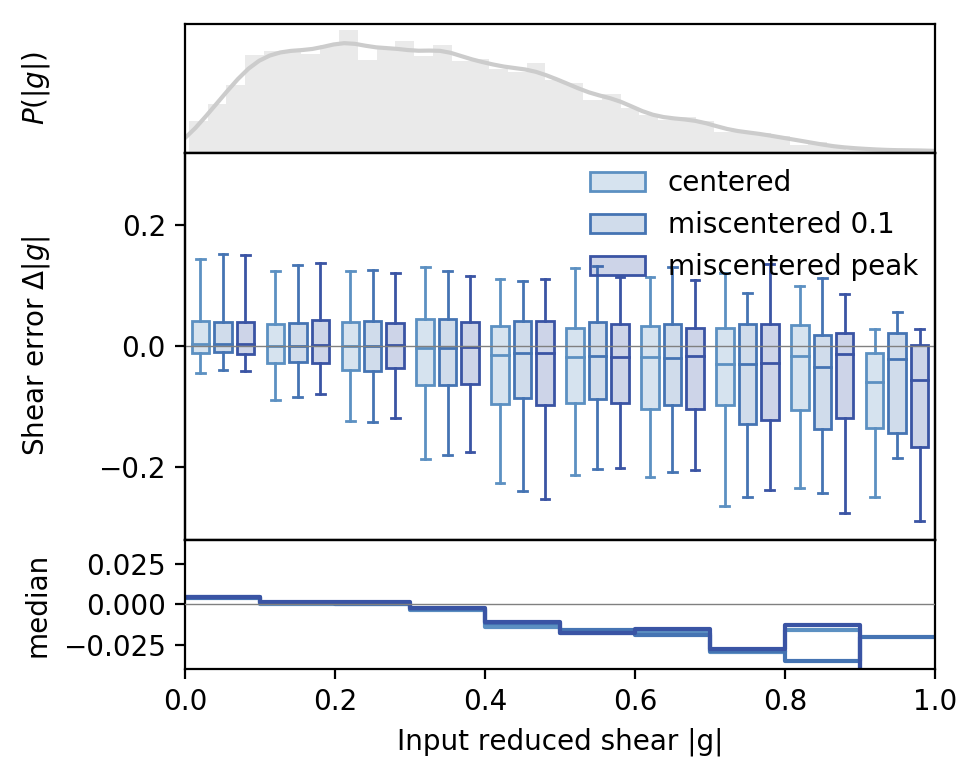

In [31]:
#fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, 
#              x = 'e_in', y = 'e_error', z = 'exp',
#              xlim = (0, 1.),
#              ylim = (-0.32, 0.32), 
#              ylim2 = (-0.04, 0.04), 
#              x_scale = 'linear',
#              legend = ['centered', 'miscentered 0.1', 'miscentered peak'],
#              x_label='Input reduced shear |g|', 
#              y_label = 'Shear error $\\Delta |g|$',
#              y_label_hist='$P(|g|)$',
#              y_label_2 = 'median',
#              legend_remove = False,
#              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.35,
#              nbins = 10)
